Цель проекта: найти пороговое значение классификатора логистической регрессии, которое бы обеспивало наилучший результат в задачах медицинского прогнозирования.

Суть проблемы.
В задачах медицинского прогназирования, когда, опираясь на характеристики человека, нужно предсказать болен он или нет, наиболее опасны 2 вида ошибок: 1) false negative - алгоритм спрогнозировал, что пациент не болен, а она оказался болен, но лечение не было начато вовремя, 2) false positive - алгоритм спрогнозировал, что человек был болен, его начали лечить химозными лекарствами и тем самым повредили его здоровье, так как на самомом деле он был здоров. Конечно, в зависимости от вида болезни важность ошибок может меняться, но мне бы хотелость найти такое значение порога, которое бы давало наилучший результат сразу по двум ошибкам.

Что значит наилучший результат? 
Задача 1) минимизации количества ошибок вида false negative сводится к минимизации следующего показателя:
$$\frac{FN}{TP+FN}\to min,$$
где $FN$ -  количество ошибок false negative, $TP$ - количество верных ответов вида true positive (алгоритм предсказал, что пациент болен, и он действительно болен), $TP + NF$ -  истинное количество больных пациентов.

Задача 2) минимизации количества ошибок вида false positive сводится к минимизации следующего показателя:
$$\frac{FP}{TN+FP}\to min,$$
где $FP$ -  количество ошибок false positive, $TN$ - количество верных ответов вида true negative (алгоритм предсказал, что пациент здоров, и он действительно здоров), $TN + FP$ -  истинное количество здоровых пациентов.

Тут хочется сделать небольшую математическую выкладку: задача min(x) эквивалентна задаче мах(1-x).

Таким образом, можно преобразовать поставленные задачи.

Задача 1):
$$1-\frac{FN}{TP+FN}\to max \equiv \frac{TP}{TP+FN}\to max,$$
где $\frac{TP}{TP+FN}$ - чувствительность алгоритма (Se), равно доле истинно больных пациентов (TPR).

Задача 2):
$$1-\frac{FP}{TN+FP}\to max \equiv \frac{TN}{TN+FP} \to max,$$
где $\frac{TN}{TN+FP}$ - специфичность алгоритма (Sp), равно доле истинно здоровных пациентов (1-FRP).

Тогда цель проекта - найти такое значение порога, которое бы обеспечивало одновременно максимальную чувствительность и специфичность модели: $max \text{ } (Se+Sp)$.



In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import numpy as np
from sklearn.metrics import confusion_matrix
%matplotlib inline


In [5]:
#загрузим данные о пациентах
data = pd.read_csv('C:/Users/olga/Downloads/diabetes.csv', index_col = 0)
# X - матрица индивидуальных характеристик, y - вектор вида [1, -1], где 1 - болен, -1 - здоров
X, y = data.iloc[:,:-1].values, data.iloc[:, -1]

#построим функцию, которая возвращает наилучший порог и AUC
def best_thresholds(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #делим на тестовую и обучающую выборку 1:4 случайно
    lr = LogisticRegression() #обучаем регрессию на обучающей подвыборке
    lr = lr.fit(X_train, y_train) 
    #строим ROC кривую, которая автоматически посчитает fpr и tpr для разного значения порога
    fpr, tpr, thresholds = metrics.roc_curve(y_test, lr.predict_proba(X_test)[:, 1]) 
    #найдем какому порогу соответствует max(Se+Sp)
    D = {'thresholds':thresholds, 'Se+Sp': -fpr + 1 +tpr}
    d1 = pd.DataFrame(data=D)
    pd.DataFrame.max(d1['Se+Sp'])
    best = d1.loc[d1['Se+Sp']==pd.DataFrame.max(d1['Se+Sp'])]
    return best, metrics.auc(fpr, tpr)

#проведем валидацию, повторив анализ 100 раз, то есть взяв 100 случайных тестовых подвыборок
best=pd.DataFrame(columns=['Se+Sp', 'thresholds'])
AUC = []
for i in range(1,100):
    A = best_thresholds(X,y)       
    AUC.append(A[1])
    best = best.append(A[0])
best_sort = best.sort_values(by = ['thresholds'])
thres = best['thresholds'].mean() #наилучший порог


Среднее AUC =  0.824922860984  а среднее значение наилучшего порога =  0.32735338828572885


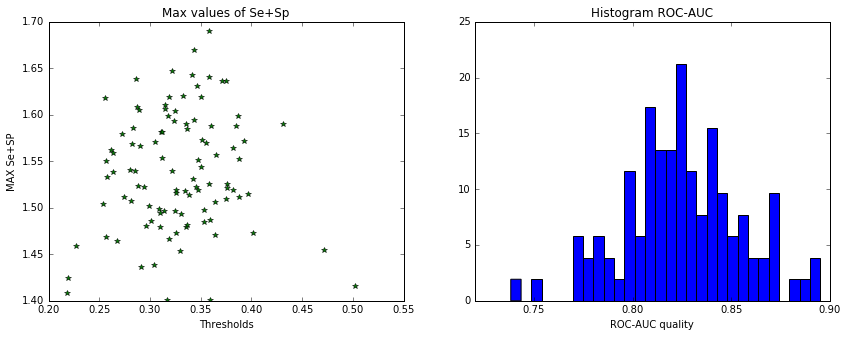

In [6]:
#вывод ответа
plt.figure(figsize=(14,5))
    
plt.subplot(1,2, 1)
plt.plot(best_sort['thresholds'], best_sort['Se+Sp'] , 'g*')
plt.title('Max values of Se+Sp')
plt.xlabel('Thresholds')
plt.ylabel('MAX Se+SP')

plt.subplot(1,2, 2)
plt.hist(AUC, 30, normed=True)
plt.xlabel('ROC-AUC quality')
plt.title('Histogram ROC-AUC')

print('Среднее AUC = ', np.mean(AUC), ' а среднее значение наилучшего порога = ', thres)


In [7]:
#так как теперь нам известно наилучшее значение порога, то можно провести классификацию на основе этих данных и найти fpr и tpr
#P.S. для точности результата сделаем так 100 раз
fpr = []
tpr = []
for i in range(1,100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    lr = LogisticRegression() #обучаем регрессию на обучающей подвыборке
    lr = lr.fit(X_train, y_train) 
    y_pred = [] #у логистической регрессии нельзя изменить порог по умолчанию, поэтому проведем классификацию вручную
    y_pred_prob = lr.predict_proba(X_test) #вероятности, которые предсказывает логист. регрессия
    for i in y_pred_prob: 
        if i[1]>= thres: #Элемент i[0] - вероятность получить -1, элемент i[1] - вероятность получить 1
            y_pred.append(1)
        else:
            y_pred.append(-1)
    CM =confusion_matrix(y_test, y_pred)
    TP, FN, FP, TN = CM[0,0], CM[0,1], CM[1,0], CM[1,1]
    tpr.append(TP/(FN+TP))
    fpr.append(FP/(TN+FP))


Среднее FPR =  0.208728304046  а среднее TPR =  0.725135084354


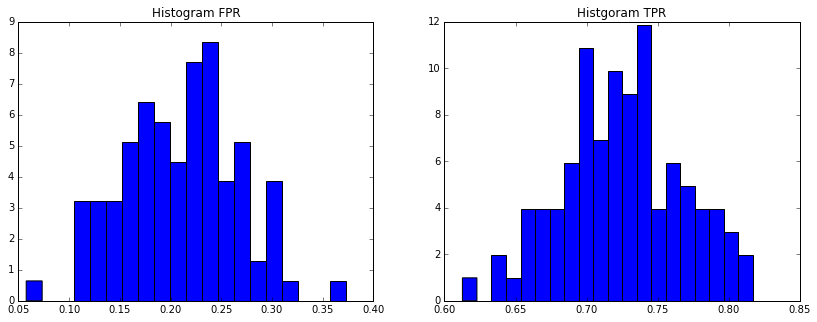

In [8]:
#вывод гистограммы для fpr, tpr
plt.figure(figsize=(14,5))
    
plt.subplot(1,2,1)
plt.hist(fpr, 20, normed=True)
plt.title('Histogram FPR')

plt.subplot(1,2, 2)
plt.hist(tpr, 20, normed=True)
plt.title('Histgoram TPR')

print('Среднее FPR = ', np.mean(fpr), ' а среднее TPR = ', np.mean(tpr))

Таким образом, наилучшее значение порога для задач медицинского прогнозирования равно 0.33-0.34, при этом значении в среднем получются высокие показатели FPR и низкие TPR. Логистическая регрессия в данном случае является действительно хорошей моделью классификации, так как значение AUC-ROC всегда больше 0.8.

Теория была написана на основе работы H. Палкина "Логистическая регрессия и ROC-анализ — математический аппарат", база данных взята из этой же работы, код для анализа полностью авторский (О. Спиридонова). 

Ссылка: https://basegroup.ru/community/articles/logistic